<h1>Imports<h1>

In [1]:
#setting rood directory into ../NeuralPowerDisaggregation
import os
os.chdir("..")
print(os.getcwd())

/work/lurny/files/Thesis


In [3]:
!pip3 freeze > requirements.txt

In [2]:
from utilities.configs import *
config1 = get_config_for_dataset('NOAA_Weather')

In [3]:
import numpy as np
np.set_printoptions(suppress=True)

import sklearn
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, ParameterGrid, ParameterSampler, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder
#from pydl85 import DL85Classifier

from livelossplot import PlotLosses

import os
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from IPython.display import Image
from IPython.display import display, clear_output

import pandas as pd

if config1['computation']['use_gpu']:
    os.environ['CUDA_VISIBLE_DEVICES'] = str(config1['computation']['gpu_numbers'])
    os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
    os.environ['XLA_FLAGS'] = "--xla_gpu_cuda_data_dir=/usr/local/cuda-11.6"
    os.environ['TF_XLA_FLAGS'] = "--tf_xla_enable_xla_devices --tf_xla_auto_jit=2"    
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = ''
    os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'false' 
#os.environ['TF_XLA_FLAGS'] = "--tf_xla_auto_jit=2 --tf_xla_cpu_global_jit" 


import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["PYTHONWARNINGS"] = "ignore"
import logging

import tensorflow as tf
import tensorflow_addons as tfa

tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)

np.seterr(all="ignore")

from keras import backend as K
from keras.utils.generic_utils import get_custom_objects


import seaborn as sns
sns.set_style("darkgrid")

import time
import random

from utilities.utilities_GDT import *
from utilities.GDT_for_streams import *

from joblib import Parallel, delayed

from itertools import product
from collections.abc import Iterable

from copy import deepcopy
from pathlib import Path
import pickle
import dill

from skmultiflow.trees import HoeffdingTreeClassifier
from skmultiflow.trees import HoeffdingAdaptiveTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from livelossplot import PlotLosses
import time

tf.random.set_seed(config1['computation']['random_seed'])
np.random.seed(config1['computation']['random_seed'])
random.seed(config1['computation']['random_seed'])

from datetime import datetime
timestr = datetime.utcnow().strftime('%Y-%m-%d--%H-%M-%S%f')
print(timestr)
os.makedirs(os.path.dirname("./evaluation_results/latex_tables/" + timestr +"/"), exist_ok=True)

filepath = './evaluation_results/depth' + str(config1['gdt']['depth']) + '/' + timestr + '/'
Path(filepath).mkdir(parents=True, exist_ok=True)    


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

2023-01-16--11-57-14805359


In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  1
Num XLA-GPUs Available:  1


In [5]:
import math
def split_df_chunks(data_df,chunk_size):
    total_length     = len(data_df)
    normal_chunk_num = math.floor(total_length/chunk_size)
    chunks = []
    for i in range(normal_chunk_num):
        chunk = data_df[(i*chunk_size):((i+1)*chunk_size)]
        chunks.append(chunk)

    return chunks

# Evaluation of agr_a dataset

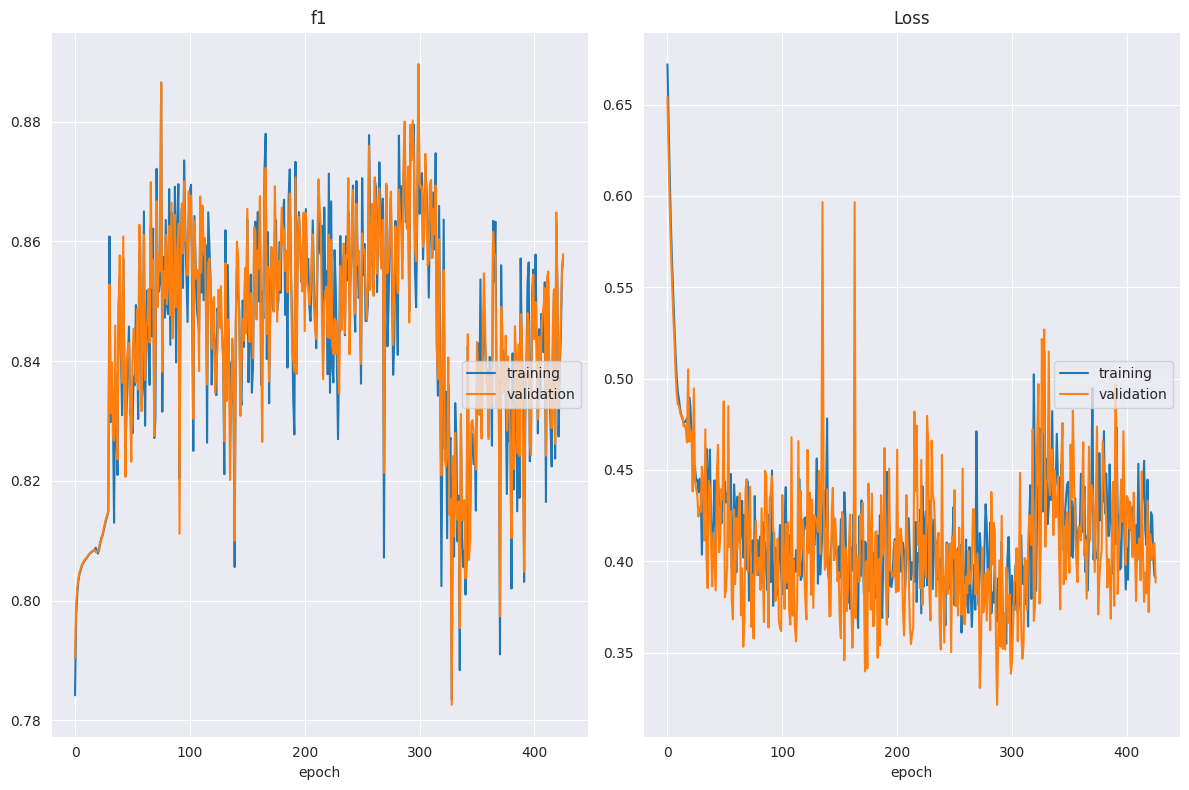

f1
	training         	 (min:    0.783, max:    0.890, cur:    0.857)
	validation       	 (min:    0.783, max:    0.890, cur:    0.858)
Loss
	training         	 (min:    0.342, max:    0.672, cur:    0.391)
	validation       	 (min:    0.322, max:    0.654, cur:    0.388)


In [7]:
#'NOAA_Weather','agr_a','agr_g','airlines','electricity','hyperplane','rbf_f',
dataset_names = ['rbf_m','sea_a','sea_g']
for dataset_name in dataset_names:
    VFDT_classifier = HoeffdingTreeClassifier()
    CVFDT_classifier = HoeffdingAdaptiveTreeClassifier(split_confidence = 0.001)
    config = get_config_for_dataset(dataset_name)

    from sklearn.metrics import cohen_kappa_score

    config_training, metrics = prepare_training_for_streams(identifier = 'BIN:'+dataset_name, config = config)
    #load Dataset
    X_data, y_data, nominal_features, ordinal_features = load_dataset_for_streams(identifier = 'BIN:'+dataset_name, 
                                                                                  max_total_samples = config['computation']['max_total_samples'])

    model_dict = {}
    scores_dict = {}
    normalizer_list = []
    plotlosses_benchmark = PlotLosses()
    verbosity = 1
    model_dict['GDT'] = GDT(number_of_variables = len(X_data.columns),
                number_of_classes = len(np.unique(y_data)),#dataset_dict['number_of_classes'],

                objective = config_training['gdt']['objective'],

                depth = config_training['gdt']['depth'],

                learning_rate_index = config_training['gdt']['learning_rate_index'],
                learning_rate_values = config_training['gdt']['learning_rate_values'],
                learning_rate_leaf = config_training['gdt']['learning_rate_leaf'],

                optimizer = config_training['gdt']['optimizer'],

                loss = 'crossentropy',

                initializer_values = config_training['gdt']['initializer_values'],
                initializer_index = config_training['gdt']['initializer_index'],
                initializer_leaf = config_training['gdt']['initializer_leaf'],        

                random_seed = config_training['computation']['random_seed'],
                verbosity = verbosity)  


    #Pretraing
    if(config_training['computation']['pretrain_size']>0 and len(X_data) > config_training['computation']['pretrain_size']):
        X_pretrain_data = X_data.iloc[:config_training['computation']['pretrain_size'],:]
        X_data = X_data.iloc[config_training['computation']['pretrain_size']:,:]
        y_pretrain_data = y_data.iloc[:config_training['computation']['pretrain_size']]
        y_data = y_data.iloc[config_training['computation']['pretrain_size']:]

        ((X_train, y_train),
         (X_valid, y_valid),
         (X_test, y_test),
         (X_train_with_valid, y_train_with_valid),
         normalizer_list) = preprocess_data(X_pretrain_data, 
                                           y_pretrain_data,
                                           nominal_features,
                                           ordinal_features,
                                           config_training,
                                           normalizer_list,
                                           random_seed= 42,#random_seed,
                                           verbosity=1)#verbosity)  
        dataset_dict = {
               'X_train': X_train,
               'y_train': y_train,
               'X_valid': X_valid,
               'y_valid': y_valid,
               'X_test': X_test,
               'y_test': y_test,
               'normalizer_list': normalizer_list
               }



        model_dict['GDT'].partial_fit(dataset_dict['X_train'],
                  dataset_dict['y_train'],

                  batch_size=config_training['gdt']['batch_size'], 
                  epochs=config_training['gdt']['pretrain_epochs'], 

                  restarts = 0,#config_test['gdt']['restarts'], 
                  #restart_type=config_test['gdt']['restart_type'], 

                  #early_stopping_epochs=config_training['gdt']['early_stopping_epochs'], 
                  #early_stopping_type=config_test['gdt']['early_stopping_type'],

                  valid_data=(dataset_dict['X_valid'],dataset_dict['y_valid']))
        
        #pretrain benchmarks
        #(X_train_with_valid, y_train_with_valid)
        temp_X_train =X_train_with_valid.values
        temp_y_train =y_train_with_valid.values
        for i in range(0, len(dataset_dict['X_train'])):
            VFDT_classifier.partial_fit(np.array([temp_X_train[i]], np.float64), np.array([temp_y_train[i]], np.float64)) 
            CVFDT_classifier.partial_fit(np.array([temp_X_train[i]], np.float64), np.array([temp_y_train[i]], np.float64))







    #Start Stream
    X_data_stream = split_df_chunks(X_data, config['computation']['chunk_size'])
    y_data_stream = split_df_chunks(y_data, config['computation']['chunk_size'])

    scores_GDT = {'train':np.array([]),
                  'valid':np.array([]),
                  'test':np.array([])
                 }
    scores_VFDT = {'train':np.array([]),
              'test':np.array([])
             }
    scores_CVFDT = {'train':np.array([]),
                  'test':np.array([])
                 }
    
    timer = {'training':{
                'GDT':0.0,
                'VFDT':0.0,
                'CVFDT':0.0,
             },
             'prediction':{
                'GDT':0.0,
                'VFDT':0.0,
                'CVFDT':0.0,
             }
            }
    flag = False;

    for i in range(len(X_data_stream)):
        normalizer_list=[]
        t0 = time.time()
        ((X_train, y_train),
         (X_valid, y_valid),
         (X_test, y_test),
         (X_train_with_valid, y_train_with_valid),
         normalizer_list) = preprocess_data(X_data_stream[i], 
                                           y_data_stream[i],
                                           nominal_features,
                                           ordinal_features,
                                           config_training,
                                           normalizer_list,
                                           random_seed= 42,#random_seed,
                                           verbosity=1)#verbosity)  
        dataset_dict = {
               'X_train': X_train,
               'y_train': y_train,
               'X_valid': X_valid,
               'y_valid': y_valid,
               'X_test': X_test,
               'y_test': y_test,
               'normalizer_list': normalizer_list
               } 

        t1 = time.time()

        t0 = time.time()
        history = model_dict['GDT'].partial_fit(dataset_dict['X_train'],
                  dataset_dict['y_train'],

                  batch_size=config_training['gdt']['batch_size'], 
                  epochs=config_training['gdt']['epochs'], 

                  restarts = 0,
                  drift_flag = flag,
                  #config_test['gdt']['restarts'], 
                  #restart_type=config_test['gdt']['restart_type'], 

                  #early_stopping_epochs=config_training['gdt']['early_stopping_epochs'], 
                  #early_stopping_type=config_test['gdt']['early_stopping_type'],

                  valid_data=(dataset_dict['X_valid'],dataset_dict['y_valid']))

        flag=False
        t1 = time.time()
        timer['training']['GDT'] = timer['training']['GDT']+t1-t0


        ###EVALUATION
        y_test_data =dataset_dict['y_test'].values
        temp_X_test = dataset_dict['X_test'].values
        temp_X_train =X_train_with_valid.values
        temp_y_train =y_train_with_valid.values


        t0 = time.time()
        #GDT
        metric = "f1"
       # y_test_data = dataset_dict['y_test']
        y_pred_GDT_train = model_dict['GDT'].predict(enforce_numpy(dataset_dict['X_train'].values))
        y_pred_GDT_train = np.nan_to_num(y_pred_GDT_train)
        y_pred_GDT_train = np.round(y_pred_GDT_train)
    
        y_pred_GDT_valid = model_dict['GDT'].predict(enforce_numpy(dataset_dict['X_valid'].values))
        y_pred_GDT_valid = np.nan_to_num(y_pred_GDT_valid)
        y_pred_GDT_valid = np.round(y_pred_GDT_valid)    
    
        y_pred_GDT_test = model_dict['GDT'].predict(enforce_numpy(temp_X_test))
        y_pred_GDT_test = np.nan_to_num(y_pred_GDT_test)
        y_pred_GDT_test = np.round(y_pred_GDT_test)
        
     
        GDT_f1_train = f1_score(dataset_dict['y_train'], y_pred_GDT_train)
        GDT_f1_valid = f1_score(dataset_dict['y_valid'], y_pred_GDT_valid)
        GDT_f1_test = f1_score(dataset_dict['y_test'], y_pred_GDT_test)

        t1 = time.time()
        timer['prediction']['GDT'] = timer['prediction']['GDT']+t1-t0
        
        
        
        
        #VFDT
        y_pred_VFDT_train = []
        y_pred_VFDT_test = []
        for i in range(0, len(temp_X_train)):
            VFDT_classifier.partial_fit(np.array([temp_X_train[i]], np.float64), np.array([temp_y_train[i]], np.float64))
        
        for i in range(0, len(temp_X_train)):
            y_pred_VFDT_train.append(VFDT_classifier.predict(np.array([temp_X_train[i]], np.float64))[0]) 
        for i in range(0, len(dataset_dict['X_test'])): 
            y_pred_VFDT_test.append(VFDT_classifier.predict(np.array([temp_X_test[i]], np.float64))[0])  
        
        VFDT_train = f1_score(temp_y_train, y_pred_VFDT_train)
        VFDT_test = f1_score(y_test_data, y_pred_VFDT_test)


        #CVFDT
        y_pred_CVFDT_train = []
        y_pred_CVFDT_test = []
        for i in range(0, len(dataset_dict['X_train'])):
            CVFDT_classifier.partial_fit(np.array([temp_X_train[i]], np.float64), np.array([temp_y_train[i]], np.float64))

        for i in range(0, len(temp_X_train)):
            y_pred_CVFDT_train.append(CVFDT_classifier.predict(np.array([temp_X_train[i]], np.float64))[0])    
        for i in range(0, len(dataset_dict['X_test'])):
            y_pred_CVFDT_test.append(CVFDT_classifier.predict(np.array([temp_X_test[i]], np.float64))[0])  
        
        CVFDT_train = f1_score(temp_y_train, y_pred_CVFDT_train)
        CVFDT_test = f1_score(y_test_data,y_pred_CVFDT_test)
                                        


    
        scores_GDT['train'] = np.append(scores_GDT['train'], GDT_f1_train)
        scores_GDT['valid'] = np.append(scores_GDT['valid'], GDT_f1_valid)
        scores_GDT['test'] = np.append(scores_GDT['test'], GDT_f1_test)
                                        
        scores_VFDT['train'] = np.append(scores_VFDT['train'], VFDT_train)
        scores_VFDT['test'] = np.append(scores_VFDT['test'], VFDT_test)
                                        
        scores_CVFDT['train'] = np.append(scores_CVFDT['train'], CVFDT_train)
        scores_CVFDT['test'] = np.append(scores_CVFDT['test'], CVFDT_test)
                                        
                                        
       
    results = pd.DataFrame(columns=['metric','train','validation','test'])
    results.loc[len(results)] = ['f1',round(np.average(scores_GDT['train']),4),round(np.average(scores_GDT['valid']),4),round(np.average(scores_GDT['test']),4)]
    results.loc[len(results)] = ['f1',round(np.average(scores_VFDT['train']),4),0,round(np.average(scores_VFDT['test']),4)]
    results.loc[len(results)] = ['f1',round(np.average(scores_CVFDT['train']),4),0,round(np.average(scores_CVFDT['test']),4)]
    results.to_csv('overfitting_results/'+dataset_name+'.csv')

In [ ]:
#train, validation, test 
